In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, roc_curve
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import average_precision_score

In [2]:
df=pd.read_csv('C:\\Users\\sanch\\OneDrive\\Desktop\\technocolab\\Cleaned_LoanData.csv')
df.head()

,CreditScore,FirstPaymentDate,FirstTimeHomebuyer,MaturityDate,MIP,Units,OCLTV,DTI,OrigUPB,LTV,...,Channel_C,Channel_R,Channel_T,DelinquencyCategory_0,DelinquencyCategory_1,DelinquencyCategory_2,RepaymentCategory_0,RepaymentCategory_1,RepaymentCategory_2,DelinquencyFlag
0,584,1999-04-01,0.0,2029-03-01,0,1,71,21,116000,71,...,0,0,1,0,0,1,1,0,0,0
1,584,1999-05-01,0.0,2029-04-01,0,1,79,28,96000,79,...,0,1,0,0,1,0,1,0,0,1
2,584,1999-05-01,0.0,2029-04-01,0,1,66,18,101000,66,...,0,1,0,0,0,1,0,1,0,0
3,584,1999-03-01,0.0,2029-02-01,0,1,65,25,66000,65,...,0,1,0,0,0,1,0,1,1,0
4,584,1999-03-01,0.0,2029-02-01,0,1,80,38,234000,80,...,0,0,1,0,0,1,0,1,0,0


### **1. Understand the Domain and Problem Statement**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290262 entries, 0 to 290261
Data columns (total 42 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   CreditScore                 290262 non-null  int64  
 1   FirstPaymentDate            290262 non-null  object 
 2   FirstTimeHomebuyer          290262 non-null  float64
 3   MaturityDate                290262 non-null  object 
 4   MIP                         290262 non-null  int64  
 5   Units                       290262 non-null  int64  
 6   OCLTV                       290262 non-null  int64  
 7   DTI                         290262 non-null  int64  
 8   OrigUPB                     290262 non-null  int64  
 9   LTV                         290262 non-null  int64  
 10  OrigInterestRate            290262 non-null  float64
 11  PropertyState               290262 non-null  object 
 12  OrigLoanTerm                290262 non-null  int64  
 13  NumBorrowers  

In [4]:
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

CreditScore: 217 unique values
FirstPaymentDate: 66 unique values
FirstTimeHomebuyer: 2 unique values
MaturityDate: 96 unique values
MIP: 37 unique values
Units: 5 unique values
OCLTV: 102 unique values
DTI: 60 unique values
OrigUPB: 206 unique values
LTV: 97 unique values
OrigInterestRate: 254 unique values
PropertyState: 53 unique values
OrigLoanTerm: 61 unique values
NumBorrowers: 3 unique values
ServicerName: 20 unique values
EverDelinquent: 2 unique values
MonthsDelinquent: 173 unique values
MonthsInRepayment: 212 unique values
ComputedLoanTerm: 62 unique values
CreditScoreCategory: 4 unique values
DTICategory: 4 unique values
LoanRiskCategory: 4 unique values
LoanPurpose_P: 2 unique values
LoanPurpose_R: 2 unique values
Occupancy_INV: 2 unique values
Occupancy_PR: 2 unique values
Occupancy_SH: 2 unique values
PropertyType_Condo: 2 unique values
PropertyType_Multi-Family: 2 unique values
PropertyType_Other: 2 unique values
PropertyType_Single-Family: 2 unique values
Channel_B: 2 u

In [5]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)
print("Datetime Columns:", datetime_cols)

Numerical Columns: ['CreditScore', 'FirstTimeHomebuyer', 'MIP', 'Units', 'OCLTV', 'DTI', 'OrigUPB', 'LTV', 'OrigInterestRate', 'OrigLoanTerm', 'EverDelinquent', 'MonthsDelinquent', 'MonthsInRepayment', 'ComputedLoanTerm', 'LoanPurpose_P', 'LoanPurpose_R', 'Occupancy_INV', 'Occupancy_PR', 'Occupancy_SH', 'PropertyType_Condo', 'PropertyType_Multi-Family', 'PropertyType_Other', 'PropertyType_Single-Family', 'Channel_B', 'Channel_C', 'Channel_R', 'Channel_T', 'DelinquencyCategory_0', 'DelinquencyCategory_1', 'DelinquencyCategory_2', 'RepaymentCategory_0', 'RepaymentCategory_1', 'RepaymentCategory_2', 'DelinquencyFlag']
Categorical Columns: ['FirstPaymentDate', 'MaturityDate', 'PropertyState', 'NumBorrowers', 'ServicerName', 'CreditScoreCategory', 'DTICategory', 'LoanRiskCategory']
Datetime Columns: []


In [6]:
# Convert to datetime
df['FirstPaymentDate'] = pd.to_datetime(df['FirstPaymentDate'], errors='coerce')
df['MaturityDate'] = pd.to_datetime(df['MaturityDate'], errors='coerce')

# Confirm the change
df[['FirstPaymentDate', 'MaturityDate']].dtypes

FirstPaymentDate    datetime64[ns]
MaturityDate        datetime64[ns]
dtype: object

In [7]:
datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
print("Datetime Columns:", datetime_cols)

Datetime Columns: ['FirstPaymentDate', 'MaturityDate']


### **2. Feature Selection**

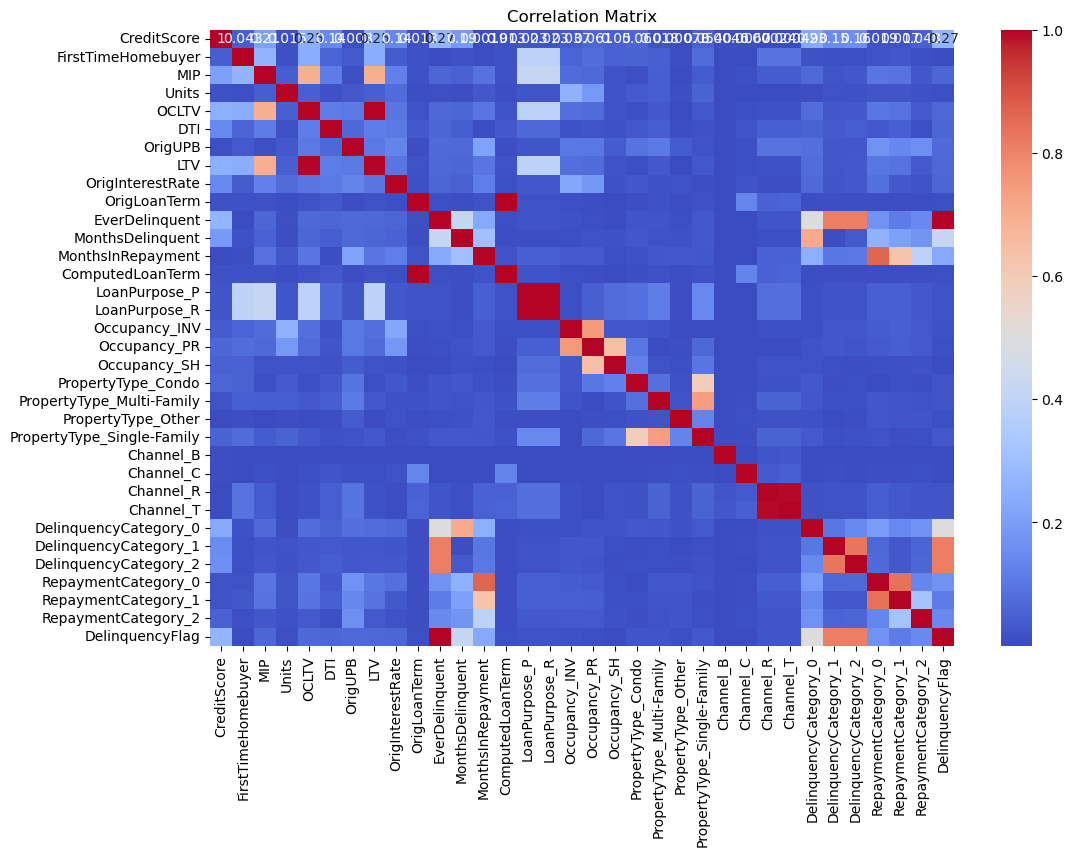

In [8]:
#Handling Multicollinearity
corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr().abs()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [9]:
# Restore the target from original data
df['DelinquencyFlag'] = pd.read_csv('C:\\Users\\sanch\\OneDrive\\Desktop\\technocolab\\Cleaned_LoanData.csv')['DelinquencyFlag']

In [10]:
#Feature Importance Technique:

X = df.drop(columns=['DelinquencyFlag'])
y = df['DelinquencyFlag']

# Encode categorical features
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
X_encoded = pd.get_dummies(X[categorical_cols], drop_first=True)

# Add numerical features back to the encoded dataframe
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
X_encoded = pd.concat([X_encoded, X[numerical_cols]], axis=1)

# Fit a random forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_encoded, y)

# Get feature importances
rf_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

rf_importance.head(10)

,Feature,Importance
93,MonthsDelinquent,0.266977
92,EverDelinquent,0.261569
110,DelinquencyCategory_1,0.179141
111,DelinquencyCategory_2,0.173709
109,DelinquencyCategory_0,0.071356
82,CreditScore,0.008831
94,MonthsInRepayment,0.008471
73,CreditScoreCategory_Fair,0.007165
79,LoanRiskCategory_Low Risk,0.004674
112,RepaymentCategory_0,0.003854


In [11]:
# Use a pipeline with scaling + L1 regularized logistic regression
lasso = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
)
lasso.fit(X_encoded, y)

# Get coefficients
lasso_coef = lasso.named_steps['logisticregression'].coef_[0]
lasso_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Lasso Coef': lasso_coef
}).sort_values('Lasso Coef', key=abs, ascending=False)

lasso_df.head(10)

,Feature,Lasso Coef
93,MonthsDelinquent,6.712997
111,DelinquencyCategory_2,-5.101267
110,DelinquencyCategory_1,4.893267
92,EverDelinquent,1.780684
109,DelinquencyCategory_0,0.919240
82,CreditScore,-0.029996
94,MonthsInRepayment,0.024277
73,CreditScoreCategory_Fair,-0.021868
112,RepaymentCategory_0,0.008856
90,OrigInterestRate,0.003468


In [12]:
# Separate features and target
X = df.drop(columns=['DelinquencyFlag'])
y = df['DelinquencyFlag']

# Encode categorical features
# Exclude datetime columns from get_dummies
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
X_encoded = pd.get_dummies(X[categorical_cols], drop_first=True)

# Add numerical features back to the encoded dataframe
# Exclude datetime columns from numerical features
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in df.select_dtypes(include=['datetime64']).columns]
X_encoded = pd.concat([X_encoded, X[numerical_cols]], axis=1)

# Compute mutual information
mi_scores = mutual_info_classif(X_encoded, y)

# Create DataFrame of scores
mi_df = pd.DataFrame({'Feature': X_encoded.columns, 'MI Score': mi_scores})
mi_df.sort_values('MI Score', ascending=False, inplace=True)
mi_df.head(10)

,Feature,MI Score
92,EverDelinquent,0.504427
93,MonthsDelinquent,0.497025
111,DelinquencyCategory_2,0.332318
110,DelinquencyCategory_1,0.286608
109,DelinquencyCategory_0,0.105009
99,Occupancy_PR,0.057255
95,ComputedLoanTerm,0.053554
91,OrigLoanTerm,0.053063
85,Units,0.049832
113,RepaymentCategory_1,0.046886


### **3. Create New Features**

In [13]:
#Mathematical Transformations:
df_fe = df.copy()

# 1. Debt-to-Income per Unit
df_fe['DTI_per_Unit'] = df_fe['DTI'] / df_fe['Units']

# 2. Loan-to-Value Ratio difference
df_fe['LTV_OCLTV_Diff'] = df_fe['LTV'] - df_fe['OCLTV']

# 3. MIP to OrigUPB ratio
df_fe['MIP_to_LoanAmt'] = df_fe['MIP'] / (df_fe['OrigUPB'] + 1)  # +1 to avoid divide by zero

# 4. Interest Rate weighted by Credit Score
df_fe['WeightedRate'] = df_fe['OrigInterestRate'] * df_fe['CreditScore']

# 5. OrigUPB to Loan Term (proxy for monthly principal)
df_fe['MonthlyPrincipal'] = df_fe['OrigUPB'] / (df_fe['OrigLoanTerm'] + 1)

# Display the new columns
df_fe[['DTI_per_Unit', 'LTV_OCLTV_Diff', 'MIP_to_LoanAmt', 'WeightedRate', 'MonthlyPrincipal']].head()

,DTI_per_Unit,LTV_OCLTV_Diff,MIP_to_LoanAmt,WeightedRate,MonthlyPrincipal
0,21.0,0,0.0,4015.0,321.329640
1,28.0,0,0.0,4015.0,265.927978
2,18.0,0,0.0,3942.0,279.778393
3,25.0,0,0.0,3869.0,182.825485
4,38.0,0,0.0,3942.0,648.199446


In [14]:
df["FirstPaymentDate"] = pd.to_datetime(df["FirstPaymentDate"], errors="coerce")

# Create a new column for year-month (monthly granularity)
df["PaymentYearMonth"] = df["FirstPaymentDate"].dt.to_period("M")

# Group by year-month and calculate aggregation metrics
aggregated_df = df.groupby("PaymentYearMonth").agg({
    "OrigUPB": "mean",             # Average Original Unpaid Principal Balance
    "CreditScore": "mean",         # Average Credit Score
    "DelinquencyFlag": "count"     # Count of loans issued that month
}).rename(columns={"DelinquencyFlag": "LoanCount"}).reset_index()

# Show the result
aggregated_df.head()

,PaymentYearMonth,OrigUPB,CreditScore,LoanCount
0,1999-01,126625.000000,716.000000,8
1,1999-02,119936.244541,710.538865,2290
2,1999-03,124571.725105,713.595770,89125
3,1999-04,124977.533040,711.854064,90800
4,1999-05,124321.863834,710.678947,103550


In [15]:
# Ensure FirstPaymentDate is in datetime format
df["FirstPaymentDate"] = pd.to_datetime(df["FirstPaymentDate"], errors="coerce")

# Extract time-based features
df["PaymentYear"] = df["FirstPaymentDate"].dt.year
df["PaymentMonth"] = df["FirstPaymentDate"].dt.month
df["PaymentQuarter"] = df["FirstPaymentDate"].dt.quarter
df["PaymentDayOfWeek"] = df["FirstPaymentDate"].dt.dayofweek  # 0 = Monday, 6 = Sunday

# Preview the new features
df[["FirstPaymentDate", "PaymentYear", "PaymentMonth", "PaymentQuarter", "PaymentDayOfWeek"]].head()

,FirstPaymentDate,PaymentYear,PaymentMonth,PaymentQuarter,PaymentDayOfWeek
0,1999-04-01,1999,4,2,3
1,1999-05-01,1999,5,2,5
2,1999-05-01,1999,5,2,5
3,1999-03-01,1999,3,1,0
4,1999-03-01,1999,3,1,0


### **4. Feature Transformation**

In [16]:
# Convert date columns
df["FirstPaymentDate"] = pd.to_datetime(df["FirstPaymentDate"], errors="coerce")
df["MaturityDate"] = pd.to_datetime(df["MaturityDate"], errors="coerce")

# Create LoanAgeMonths as a domain-specific feature
df["LoanAgeMonths"] = ((df["MaturityDate"] - df["FirstPaymentDate"]) / pd.Timedelta(days=30)).round()

In [17]:
#Normalization:
minmax_features = ["CreditScore", "OrigUPB", "DTI", "LoanAgeMonths"]

# Apply Min-Max Scaling
minmax_scaler = MinMaxScaler()
df_minmax_scaled = df[minmax_features].copy()
df_minmax_scaled[minmax_features] = minmax_scaler.fit_transform(df_minmax_scaled)

df_minmax_scaled.head()

,CreditScore,OrigUPB,DTI,LoanAgeMonths
0,0.0,0.395122,0.355932,0.983607
1,0.0,0.297561,0.474576,0.983607
2,0.0,0.321951,0.305085,0.983607
3,0.0,0.151220,0.423729,0.983607
4,0.0,0.970732,0.644068,0.983607


In [18]:
# Z-score Standardization
df_zscore_scaled = df[minmax_features].copy()
df_zscore_scaled = (df_zscore_scaled - df_zscore_scaled.mean()) / df_zscore_scaled.std()

df_zscore_scaled.head()

,CreditScore,OrigUPB,DTI,LoanAgeMonths
0,-2.539615,-0.165952,-0.685302,0.07186
1,-2.539615,-0.545562,-0.153377,0.07186
2,-2.539615,-0.450660,-0.913270,0.07186
3,-2.539615,-1.114978,-0.381344,0.07186
4,-2.539615,2.073749,0.606516,0.07186


In [19]:
# Log Transformation
log_features = ["OrigUPB", "LoanAgeMonths"]
df_log_transformed = df[log_features].copy()
df_log_transformed = np.log1p(df_log_transformed)

df_log_transformed.head()

,OrigUPB,LoanAgeMonths
0,11.661354,5.899897
1,11.472114,5.899897
2,11.522886,5.899897
3,11.097425,5.899897
4,12.363081,5.899897


In [20]:
# Polynomial Features:
poly_features = df[["CreditScore", "OrigUPB", "DTI"]].copy()

# Create polynomial and interaction terms
df_poly = pd.DataFrame()
df_poly["CreditScore^2"] = poly_features["CreditScore"] ** 2
df_poly["OrigUPB^2"] = poly_features["OrigUPB"] ** 2
df_poly["DTI^2"] = poly_features["DTI"] ** 2
df_poly["CreditScore*OrigUPB"] = poly_features["CreditScore"] * poly_features["OrigUPB"]
df_poly["CreditScore*DTI"] = poly_features["CreditScore"] * poly_features["DTI"]
df_poly["OrigUPB*DTI"] = poly_features["OrigUPB"] * poly_features["DTI"]

df_poly.head()

,CreditScore^2,OrigUPB^2,DTI^2,CreditScore*OrigUPB,CreditScore*DTI,OrigUPB*DTI
0,341056,13456000000,441,67744000,12264,2436000
1,341056,9216000000,784,56064000,16352,2688000
2,341056,10201000000,324,58984000,10512,1818000
3,341056,4356000000,625,38544000,14600,1650000
4,341056,54756000000,1444,136656000,22192,8892000


In [21]:
#  Quantile Transformation:
quantile_features = ["CreditScore", "OrigUPB", "DTI"]
df_quantile = df[quantile_features].copy()

# Apply rank transformation and scale to [0,1]
df_quantile = df_quantile.rank(method='average') / len(df_quantile)

df_quantile.head()

,CreditScore,OrigUPB,DTI
0,0.005138,0.492958,0.220139
1,0.005138,0.343824,0.408510
2,0.005138,0.386945,0.162057
3,0.005138,0.127798,0.317386
4,0.005138,0.959981,0.726490


### **5. Feature Scaling**

In [22]:
# Robust Scaling:
robust_features = ["CreditScore", "OrigUPB", "DTI"]
df_robust_scaled = df[robust_features].copy()

# Median and IQR-based scaling
Q1 = df_robust_scaled.quantile(0.25)
Q3 = df_robust_scaled.quantile(0.75)
IQR = Q3 - Q1

df_robust_scaled = (df_robust_scaled - df_robust_scaled.median()) / IQR

df_robust_scaled.head()

,CreditScore,OrigUPB,DTI
0,-1.727273,-0.012987,-0.588235
1,-1.727273,-0.272727,-0.176471
2,-1.727273,-0.207792,-0.764706
3,-1.727273,-0.662338,-0.352941
4,-1.727273,1.519481,0.411765


In [23]:
# Max-Abs Scaling
maxabs_features = ["CreditScore", "OrigUPB", "DTI"]
df_maxabs_scaled = df[maxabs_features].copy()

# Divide each value by the maximum absolute value of its column
df_maxabs_scaled = df_maxabs_scaled / df_maxabs_scaled.abs().max()

df_maxabs_scaled.head()

,CreditScore,OrigUPB,DTI
0,0.73,0.483333,0.355932
1,0.73,0.400000,0.474576
2,0.73,0.420833,0.305085
3,0.73,0.275000,0.423729
4,0.73,0.975000,0.644068


### **6. Feature Reduction**

In [24]:
# Select numerical features and drop rows with NaNs
pca_features = df[["CreditScore", "OrigUPB", "DTI", "LoanAgeMonths", "LTV", "OCLTV"]].dropna()

# Standardize before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pca_features)

# Apply PCA to retain 95% variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Convert to DataFrame
df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
df_pca.head()

,PC1,PC2,PC3,PC4,PC5
0,-0.111665,-0.554109,-0.628519,1.024477,2.343482
1,-0.843240,-0.681368,-0.870486,1.286709,1.795550
2,0.396817,-0.480005,-0.861546,1.150005,2.463924
3,0.478533,-0.807516,-1.245799,1.642304,1.985449
4,-1.410811,-1.573951,1.357163,0.191821,2.204004


In [25]:
# Prepare data: ensure all values are non-negative for chi2
chi_features = df[["CreditScore", "OrigUPB", "DTI", "LTV", "OCLTV"]].fillna(0)
target = df["DelinquencyFlag"].fillna(0).astype(int)

# Apply Chi-Square test
chi_selector = SelectKBest(score_func=chi2, k='all')
chi_selector.fit(chi_features, target)

# Show scores
pd.Series(chi_selector.scores_, index=chi_features.columns).sort_values(ascending=False)

OrigUPB        2.937125e+07
CreditScore    7.401291e+04
DTI            6.528454e+03
LTV            3.771433e+03
OCLTV          3.752213e+03
dtype: float64

In [26]:
# Fill missing values and scale
lasso_X = chi_features.copy()
lasso_y = target

# Fit LassoCV to select features
lasso = LassoCV(cv=5).fit(lasso_X, lasso_y)

# Display coefficients
pd.Series(lasso.coef_, index=lasso_X.columns).sort_values(ascending=False)

DTI            0.000000e+00
LTV            0.000000e+00
OCLTV          0.000000e+00
OrigUPB       -5.209531e-07
CreditScore   -1.558346e-03
dtype: float64

In [27]:
# Use logistic regression with RFE
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=3)
rfe.fit(lasso_X, lasso_y)

# Show selected features
pd.Series(rfe.support_, index=lasso_X.columns)

CreditScore     True
OrigUPB        False
DTI            False
LTV             True
OCLTV           True
dtype: bool

In [28]:
selected_features = lasso_X.columns[rfe.support_]
print("Selected Features:", selected_features.tolist())

Selected Features: ['CreditScore', 'LTV', 'OCLTV']


In [29]:
X_selected = lasso_X[selected_features]
y = lasso_y

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [31]:
final_model = LogisticRegression(max_iter=1000)
final_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [32]:
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

In [33]:
print("\n Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.99      0.89     46782
           1       0.46      0.04      0.07     11271

    accuracy                           0.80     58053
   macro avg       0.63      0.51      0.48     58053
weighted avg       0.74      0.80      0.73     58053

ROC-AUC Score: 0.6856148004437006


C:\Users\sanch\AppData\Local\Temp\ipykernel_4344\3190369741.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray')


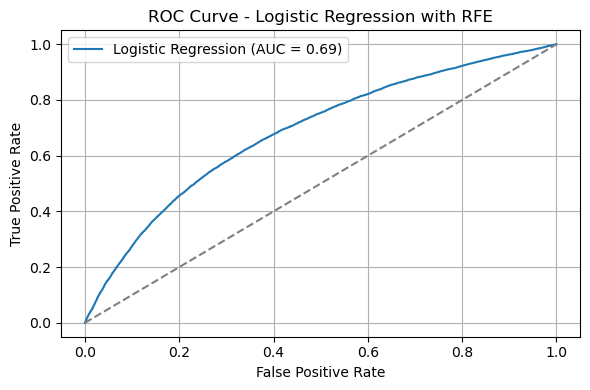

In [34]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], 'k--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression with RFE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
}

In [41]:
grid_search = GridSearchCV(estimator=LogisticRegression(max_iter=1000), param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

In [42]:
grid_search.fit(X_train, y_train)

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1172, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [43]:
print("Best Hyperparameters Found:", grid_search.best_params_)

Best Hyperparameters Found: {'C': 0.1, 'penalty': 'l2'}


In [44]:
best_model = grid_search.best_estimator_

In [45]:
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]

In [46]:
print("Best Model ROC-AUC Score (Test Set):", roc_auc_score(y_test, y_proba_best))

Best Model ROC-AUC Score (Test Set): 0.6856152726786362


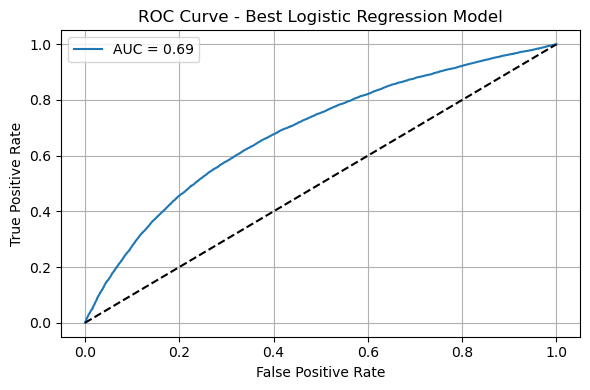

In [47]:
#ROC Curve for Best Model
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc_score(y_test, y_proba_best)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Best Logistic Regression Model")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [50]:
# Precision-Recall Curve for Best Model
precision, recall, _ = precision_recall_curve(y_test, y_proba_best)
avg_precision = average_precision_score(y_test, y_proba_best)
print("Best Model Average Precision Score:", avg_precision)

Best Model Average Precision Score: 0.3375752674014722


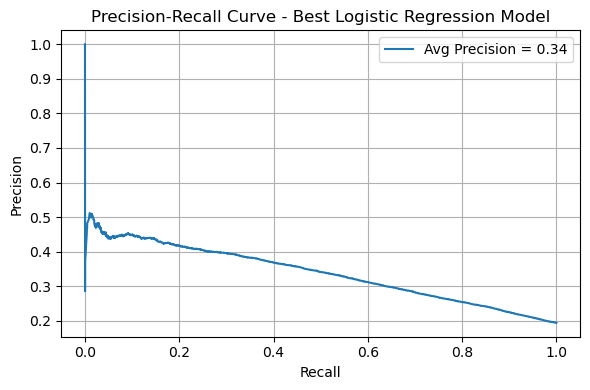

In [51]:
# Precision-Recall Curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label='Avg Precision = {:.2f}'.format(avg_precision))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Best Logistic Regression Model")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [52]:
# Classification Report for Best Model
print("\n📊 Best Model Classification Report (Test Set):\n", classification_report(y_test, y_pred_best))


📊 Best Model Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.81      0.99      0.89     46782
           1       0.46      0.04      0.07     11271

    accuracy                           0.80     58053
   macro avg       0.63      0.51      0.48     58053
weighted avg       0.74      0.80      0.73     58053

